In [1]:
#importing libraries
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read data
data = pd.read_csv("pos_tagged_new.csv")
data.dropna(inplace=True)

In [3]:
#make a copy of data
data_text = data["text"].copy()

In [4]:
import ast
data['tagged_tokens'] = data['tagged_tokens'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])

In [5]:
data.drop(columns = ["text","lemmatized_processed_text","tokens"], inplace = True)
data.head()

,class,tagged_tokens
0,suicide,"[ex_NN, wife_NN, threatening_VBG, suicide_NN, ..."
1,non-suicide,"[weird_JJ, get_VB, affected_VBN, compliment_NN..."
2,non-suicide,"[finally_RB, almost_RB, never_RB, hear_VB, bad..."
3,suicide,"[need_NN, help_NN, help_NN, cry_NN, hard_RB]"
4,suicide,"[lost_VBN, hello_UH, name_NN, adam_NN, struggl..."


In [6]:
#convert to string of words
data["tagged_tokens"] = data["tagged_tokens"].apply(lambda x: " ".join(x))
data.head()

,class,tagged_tokens
0,suicide,ex_NN wife_NN threatening_VBG suicide_NN recen...
1,non-suicide,weird_JJ get_VB affected_VBN compliment_NN com...
2,non-suicide,finally_RB almost_RB never_RB hear_VB bad_JJ y...
3,suicide,need_NN help_NN help_NN cry_NN hard_RB
4,suicide,lost_VBN hello_UH name_NN adam_NN struggling_V...


In [7]:
train_X, test_X, train_y, test_y = train_test_split(data['tagged_tokens'],data['class'],test_size=0.3, random_state = 42)

In [8]:
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(train_X)
#applying tf idf to training data
X_train_tf = tf_idf.transform(train_X)

In [9]:
#print dimension of data
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 162411, n_features: 44044


In [10]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(test_X)

#print dimension of data
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 69606, n_features: 44044


### Naive Bayes

In [11]:
#Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, train_y)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test_tf)

In [12]:
print(metrics.classification_report(test_y, y_pred_nb, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.95      0.83      0.88     34757
     Suicide       0.85      0.95      0.90     34849

    accuracy                           0.89     69606
   macro avg       0.90      0.89      0.89     69606
weighted avg       0.90      0.89      0.89     69606



In [13]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred_nb, test_y)*100)

Naive Bayes Accuracy Score ->  89.1388673390225


In [14]:
#Naive Bayes Confusion Matrix
print("Naive Bayes Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_nb))

Naive Bayes Confusion Matrix:
[[28797  5960]
 [ 1600 33249]]


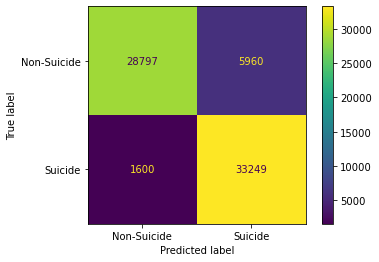

In [15]:
nb_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_nb)

nb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

nb_cm_display.plot()
plt.show()

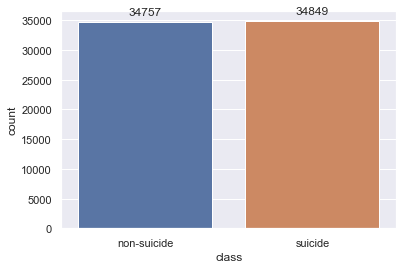

In [16]:
sns.set(style="darkgrid")
ax = sns.countplot(x=test_y)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


In [17]:
# convert test_y and y_pred_logreg to numpy arrays
test_y = test_y.to_numpy()
y_pred_nb = np.array(y_pred_nb)

# find misclassified samples
nb_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_nb[i]]
print(len(nb_misclassified_indices))

7560


In [18]:
# create a dataframe with test_X and their true and predicted labels
df_test_nb = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_nb})

nb_misclassified_df = df_test_nb.iloc[nb_misclassified_indices]

In [19]:
nb_misclassified_df.head()

,text,true_label,predicted_label
28247,depressed_JJ definitely_RB ok_UH recently_RB f...,non-suicide,suicide
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
213094,gain_NN confidence_NN around_RB people_NNS kno...,non-suicide,suicide
25688,professor_NN pulled_VBN aside_RB class_NN toda...,non-suicide,suicide


In [20]:
# merge misclassified_df with data based on the index
nb_misclassified_merged = pd.merge(nb_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
nb_misclassified_merged_df = pd.DataFrame(nb_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [21]:
nb_misclassified_merged_df.to_csv("misclassified_naive_bayes.csv")

### Logistic Regression

In [22]:
# fit the training dataset on the Logistic Regression classifier
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_tf,train_y)
# predict the labels on validation dataset
y_pred_logreg = logreg.predict(X_test_tf)

In [23]:
print(metrics.classification_report(test_y, y_pred_logreg, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.95      0.94     34757
     Suicide       0.95      0.93      0.94     34849

    accuracy                           0.94     69606
   macro avg       0.94      0.94      0.94     69606
weighted avg       0.94      0.94      0.94     69606



In [24]:
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_pred_logreg, test_y)*100)

Logistic Regression Accuracy Score ->  93.73329885354711


In [25]:
#Log Reg Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_logreg))

Logistic Regression Confusion Matrix:
[[32920  1837]
 [ 2525 32324]]


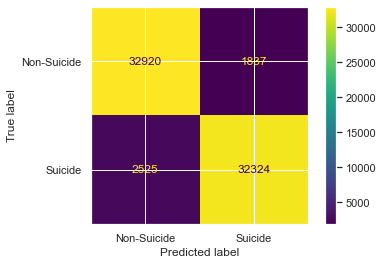

In [26]:
logreg_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_logreg)

logreg_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

logreg_cm_display.plot()
plt.show()

In [27]:
# convert test_y and y_pred_logreg to numpy arrays
y_pred_logreg = np.array(y_pred_logreg)

# find misclassified samples
logreg_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_logreg[i]]
print(len(logreg_misclassified_indices))

4362


In [28]:
# create a dataframe with test_X and their true and predicted labels
df_test_logreg = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_logreg})

logreg_misclassified_df = df_test_logreg.iloc[logreg_misclassified_indices]

In [29]:
logreg_misclassified_df.head()

,text,true_label,predicted_label
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
664,adopt_VB mep_NN l_NN,suicide,non-suicide
44196,know_VB need_NN help_NN trust_NN anyone_NN exp...,suicide,non-suicide
169038,anyone_NN else_RB think_VB deserve_VB live_RB,non-suicide,suicide


In [30]:
# merge misclassified_df with data based on the index
logreg_misclassified_merged = pd.merge(logreg_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
logreg_misclassified_merged_df = pd.DataFrame(logreg_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [31]:
logreg_misclassified_merged_df.to_csv("misclassified_logistic_regression.csv")

In [32]:
#sample prediction
test = ['i want to die. cannot live any longer. help']

In [33]:
review = re.sub('[^a-zA-Z]', ' ', test[0])
review = review.lower()
review = review.split()
stop_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
review = [lemmatizer.lemmatize(word) for word in review if not word in stop_list]

In [34]:
# Create a function to add POS tags in the form of word_POS
def add_pos_tag(sentences):
    tagged_sentences = []
    for sentence in sentences:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sentence)
        # Get POS tags for words
        pos_tags = nltk.pos_tag(words)
        # Join word and POS tag into word_POS format
        tagged_words = [f"{word}_{pos}" for word, pos in pos_tags]
        # Join tagged words into sentence
        tagged_sentence = " ".join(tagged_words)
        # Add tagged sentence to list
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

test_tagged = add_pos_tag(review)
print(test_tagged)

['want_NN', 'die_NN', 'can_MD not_RB', 'live_JJ', 'longer_NN', 'help_NN']


In [35]:
test_processed =[ ' '.join(test_tagged)]
test_processed

['want_NN die_NN can_MD not_RB live_JJ longer_NN help_NN']

In [36]:
test_input = tf_idf.transform(test_processed)
test_input.shape

(1, 44044)

In [37]:
#Naive Bayes
nb_result = naive_bayes_classifier.predict(test_input)[0]
nb_result

'suicide'

In [38]:
#LogReg
logreg_result = logreg.predict(test_input)[0]
logreg_result

'suicide'